In [1]:
import sys
import shap 
import pickle
import sklearn 
import numpy as np
import matplotlib.pyplot as plt


In [2]:

sys.path.append("../")

from dd_package.data.dyslexia_data import DyslexiaData
from dd_package.data.preprocess import preprocess_data

from dd_package.models.regression_estimators import RegressionEstimators

from dd_package.common.utils import save_a_dict, load_a_dict






# demo-Fcls-mm:

- Chosen model: **MLP**



https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/

## Load Data

In [3]:

dd = DyslexiaData(path="../../datasets/", n_repeats=5)
to_exclude_at_risk = 0



data_name = "dd_fix_demo"




In [4]:


if data_name == "dd_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    df_data_to_use = demo_phono.loc[:, [
                                           'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
                                       ]]
    c_features = ['Sex', 'Grade', ]
    indicators = ['SubjectID', ]
    targets = ["Group", "Reading_speed", ]

elif data_name == "dd_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    _ = dd.get_fix_datasets()  # fixes

    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_demo = dd.concat_dfs(
        df1=fix,
        df2=demo_phono,
        features1=fix.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", "Reading_speed", ]
    
elif data_name == "dd_fix":

    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_fix_datasets()  # fixes
    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]

    df_data_to_use = fix
    c_features = None
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", ]
    
    

Loading Demo data: 
  dyslexia (72, 9)
  norm (213, 9)
  risk (22, 9)
 
Loading Fixation report data:
  dyslexia (59770, 7)
  norm (139507, 7)
  risk (26073, 7)
 


In [5]:

df_data_to_use.head()



,Group,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION,Sex,Grade,Age,IQ,Reading_speed
0,1,10,4,1,177.3,531.8,219.0,1,4,10,23,102.0
1,1,10,4,2,200.5,545.2,247.0,1,4,10,23,102.0
2,1,10,4,3,282.7,542.4,261.0,1,4,10,23,102.0
3,1,10,4,4,358.1,545.5,268.0,1,4,10,23,102.0
4,1,10,4,4,392.8,536.3,129.0,1,4,10,23,102.0


In [6]:


x_org, y_org = dd.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)



In [7]:

x_org.head()



,Grade_1,Grade_5,Grade_3,IQ,FIX_DURATION,Grade_6,Sex_1,Sex_2,Grade_2,FIX_Y,Grade_4,Age,FIX_X
0,0,0,0,23,219.0,0,1,0,0,531.8,1,10,177.3
1,0,0,0,23,247.0,0,1,0,0,545.2,1,10,200.5
2,0,0,0,23,261.0,0,1,0,0,542.4,1,10,282.7
3,0,0,0,23,268.0,0,1,0,0,545.5,1,10,358.1
4,0,0,0,23,129.0,0,1,0,0,536.3,1,10,392.8


In [54]:
# for i in range(x_org.Sex_1.values.shape[0]):
#     print(x_org.Sex_1.values[i], x_org.Sex_2.values[i])

In [86]:

y_org.head()



,Group,Reading_speed
0,1,102.0
1,1,102.0
2,1,102.0
3,1,102.0
4,1,102.0


In [9]:


estimator_name = "MLP_cls"

if estimator_name.split("_")[-1] == "reg":
    learning_method = "regression"
    y = y_org.Reading_speed.values

elif estimator_name.split("_")[-1] == "cls":
    learning_method = "classification"
    y = y_org.Group.values

elif estimator_name.split("_")[-1] == "clu":
    from dd_package.models.clustering_estimators import ClusteringEstimators
    y = y_org.Group.values
else:
    assert False, "Undefined algorithm and thus undefined target values"
    
print("learning_method:", learning_method)



learning_method: classification


In [10]:

x = preprocess_data(x=x_org, pp="mm")  # only x is standardized



pre-processing: mm
Preprocessed data shape: (225350, 13)


In [11]:

data = dd.get_stratified_train_test_splits(
        x=x, y=y,
        labels=y_org.Group.values,
        to_shuffle=True,
        n_splits=2
    )



In [87]:

# data



## Load the tuned parameters

In [13]:

if data_name == "dd_fix_demo":
    print(data_name)
    with open("../../Params/dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:0.pickle", "rb") as fp:
        tuned_params = pickle.load(fp)
        
elif data_name == "dd_demo":
    print(data_name)
    with open("../../Params/dd_demo-mlp_cls--shuffled:True--exclude at risk:0.pickle", "rb") as fp:
        tuned_params = pickle.load(fp)
    
    
    

dd_fix_demo


In [170]:

tuned_params



OrderedDict([('activation', 'tanh'),
             ('hidden_layer_sizes', 158),
             ('max_iter', 49150),
             ('solver', 'lbfgs')])

In [171]:

mdl = sklearn.neural_network.MLPClassifier(
    activation=tuned_params["activation"], 
    hidden_layer_sizes=tuned_params["hidden_layer_sizes"],
    max_iter=tuned_params["max_iter"],
    solver=tuned_params["solver"],
    verbose=0
)

mdl

MLPClassifier(activation='tanh', hidden_layer_sizes=158, max_iter=49150,
              solver='lbfgs', verbose=0)

In [172]:
x_train = data["1"]["x_train"]
x_test = data["1"]["x_test"]
y_train = data["1"]["y_train"]
y_test = data["1"]["y_test"]



In [173]:
mdl_name = "dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:0.joblib"

mdl_name

'dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:0.joblib'

In [18]:

from joblib import dump, load



In [19]:

mdl = load("../../Models/"+mdl_name)
mdl




MLPClassifier(activation='tanh', hidden_layer_sizes=158, max_iter=49150,
              solver='lbfgs')

In [20]:


# mdl.fit(x_train, y_train)




In [21]:

print("model fitted")



model fitted


In [22]:
mdl.predict_proba(x_test[70:75:, :])


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [23]:
mdl.predict(x_test[70:75:, :])



array([3, 3, 3, 1, 1])

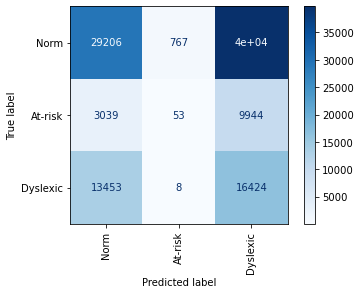

In [24]:


class_names = ['Norm', 'At-risk', 'Dyslexic']

disp = sklearn.metrics.plot_confusion_matrix(
    mdl, x_test, y_test, 
    display_labels=class_names, 
    cmap=plt.cm.Blues, 
    xticks_rotation='vertical'
)



In [169]:
sklearn.metrics.roc_auc_score(y_test, mdl.predict_proba(x_test),
                              multi_class="ovr",
                              average="weighted")




0.5220681452372042

- Not that good performance, as it was demonstrated by the correponding tables!


In [25]:


len(list(x_org.columns)) == x_test.shape[1]




True

In [26]:
explainer = shap.Explainer(mdl.predict, x_test, feature_names=list(x_org.columns))



In [27]:


shap_values = explainer(x_test)




Permutation explainer:  13%|█████████████▋                                                                                               | 14094/112675 [42:42<5:25:14,  5.05it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Permutation explainer:  42%|█████████████████████████████████████████████▎                                                             | 47776/112675 [2:31:17<3:55:49,  4.59it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (s

In [28]:


print("Shap values are determined!")



Shap values are determined!


In [89]:


y_test.shape, x_test.shape, shap_values.values.shape



((112675,), (112675, 13), (112675, 13))

### SHAP Summary Plots


Permutation importance numerically measures the importance of features. This simplifies the comparison between features.  However, the considered interaction between features during the features importance determination process, as can be considered a severe drawback of this method. SHAP summary plots give us a birds-eye view of feature importance and what is driving it. 




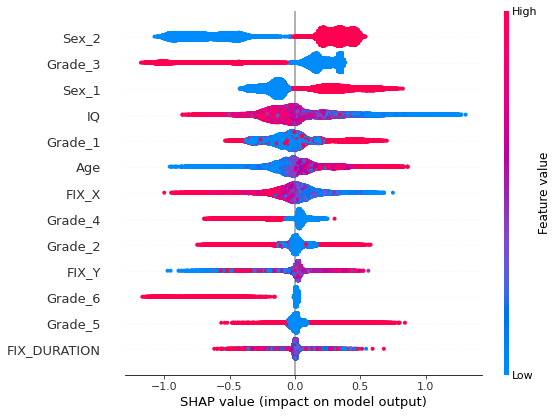

In [30]:
shap.summary_plot(shap_values=shap_values.values, 
                  features=x_test,
                  class_names=["Norm", "at-risk", "Dyslexic"],
                  feature_names=list(x_org.columns), 
                 )



- what does row explain?  sorted features' importance in ascending order, low to high.
- what does each dot explain? data points
- what does color explain? data points per feature value

Interpret: 

- The are various male students (sex_2=1) which have large SHAP values leading to high positive impacts on model's predictions. 

- On the contary, there are various 3rd grade students which have high negative impacts on model's predictions.

-


In [148]:
# shap.summary_plot(shap_values, 
#                   x_test, 
#                   plot_type="bar", 
#                   class_names=class_names, 
#                   feature_names=list(x_org.columns),
#                   alpha=0.1,
#                   color_bar=True,
#                   color_bar_label=True
#                  )



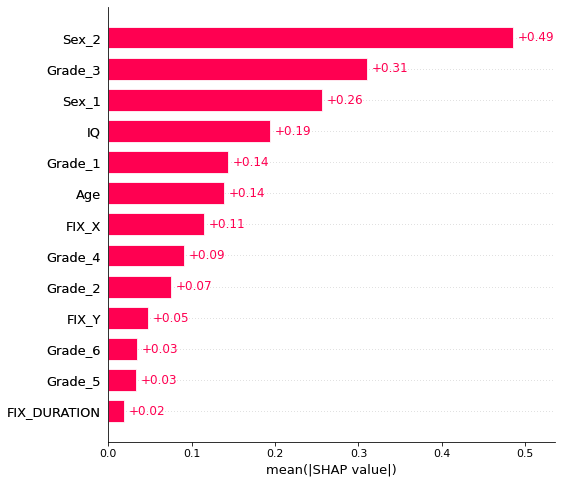

In [149]:
shap.plots.bar(shap_values, max_display=99, show=False)
# plt.gcf()
# plt.savefig("plots/bar.png")

### Shap bar plot


Creating legend with loc="best" can be slow with large amounts of data.
Creating legend with loc="best" can be slow with large amounts of data.


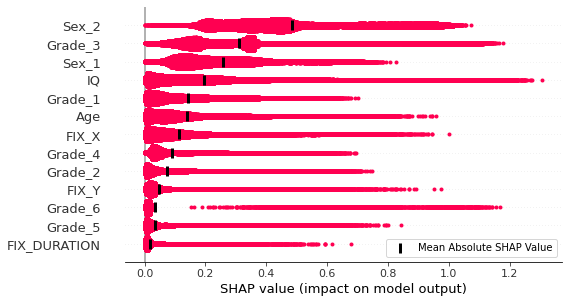

In [151]:
plt.gcf()
shap.plots.bar(shap_values.abs.max(0), max_display=99, show=False)
plt.subplot(2, 1, 2)
shap.plots.beeswarm(
    shap_values.abs, color="shap_red", max_display=99, show=False, plot_size=None
)
ax = plt.gca()
masv = {}

for feature in ax.get_yticklabels():
    name = feature.get_text()
    col_ind = x_org.columns.get_loc(name)
    mean_abs_sv = np.mean(np.abs(shap_values.values[:, col_ind]))
    masv[name] = mean_abs_sv
ax.scatter(
    masv.values(),
    [i for i in range(len(x_org.columns))],
    zorder=99,
    label="Mean Absolute SHAP Value",
    c="k",
    marker="|",
    linewidths=3,
    s=100,
)
ax.legend(frameon=True)
plt.tight_layout()


# plt.savefig("plots/bar_beeswarm.png")

##### Beeswarm-bar plot: 

- 

### SHAP Dependence Contribution Plots

A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model. SHAP dependence contribution plots provide a similar insight to PDP's, but they add a lot more detail.


- Each dot is a single prediction (row) from the dataset.
- The x-axis is the actual value from the dataset.
- The y-axis is the SHAP value for that feature, which represents how much knowing that feature’s value changes the output of the model for that sample’s prediction.

FixedFormatter should only be used together with FixedLocator


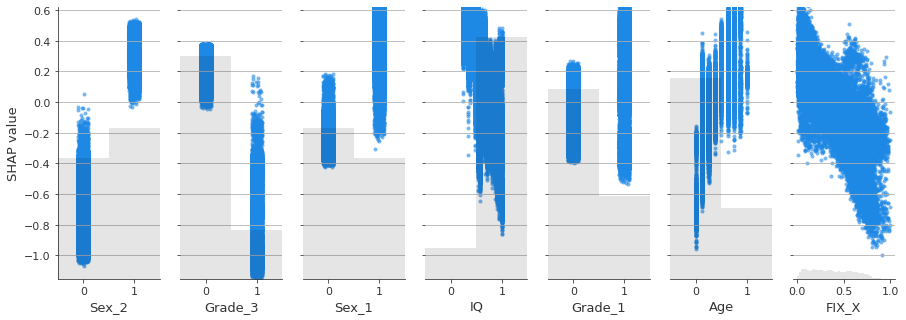

In [160]:
n = 7
fig, ax = plt.subplots(1, n, figsize=(15, 5))

for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
    if i < n:
        shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
        ax[i].grid(axis="y")
        if i != 0:
            ax[i].set_ylabel("")
            ax[i].spines["left"].set_visible(False)
            ax[i].set_ylim(ax[0].get_ylim())
            ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
        else:
            ax[i].set_ylabel("SHAP value")
# fig.savefig("plots/scatter_top5.png")

In [161]:
# n = 5
# fig, ax = plt.subplots(1, n, figsize=(15, 5))

# for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
#     if i < n:
#         shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
#         ax[i].grid(axis="y")
#         if i != 0:
#             ax[i].set_ylabel("")
#             ax[i].spines["left"].set_visible(False)
#             ax[i].set_ylim(ax[0].get_ylim())
#             ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
#         else:
#             ax[i].set_ylabel("SHAP value")
# # fig.savefig("plots/scatter_top5.png")

##### Dependece plots:

- 


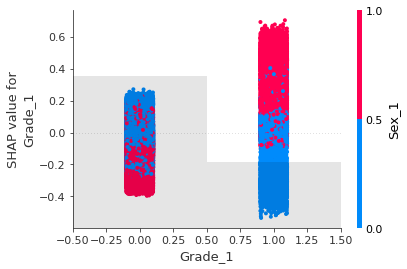

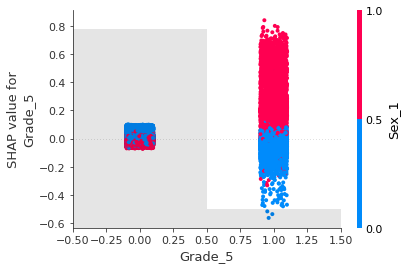

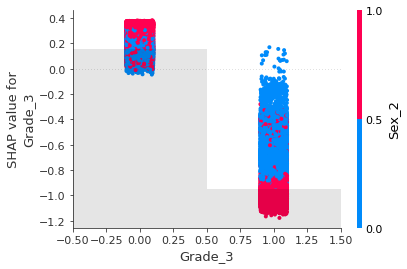

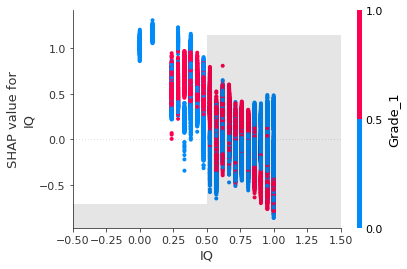

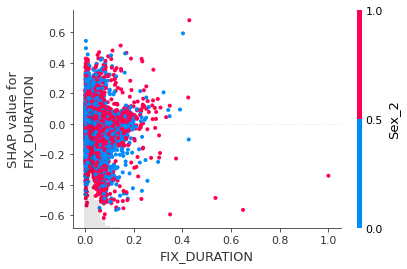

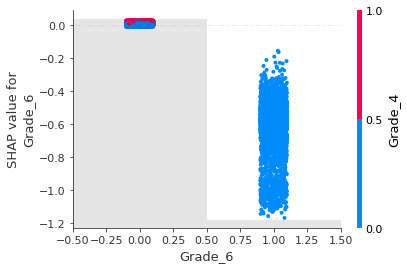

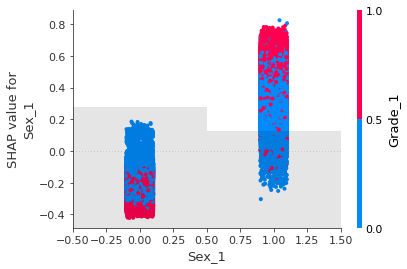

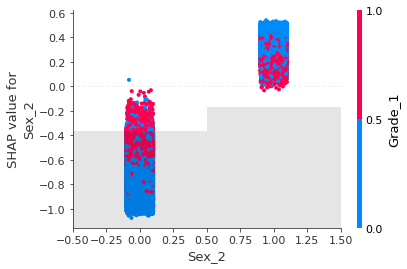

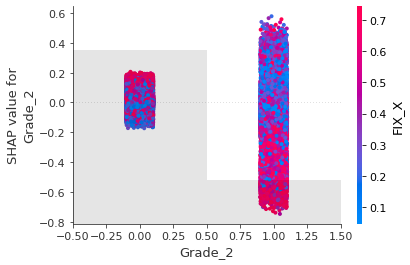

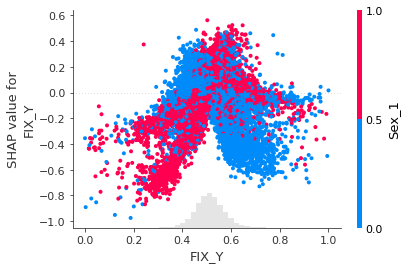

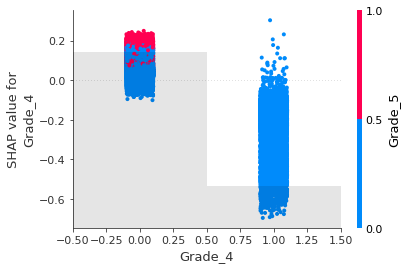

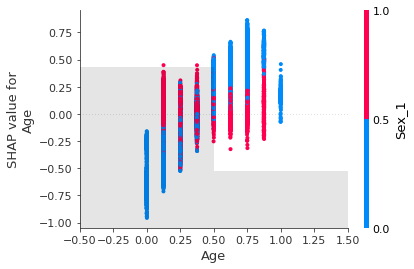

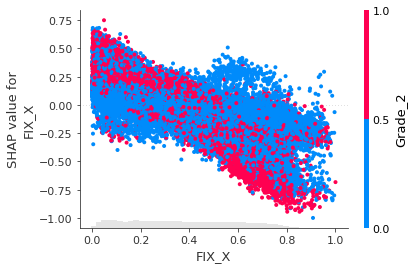

In [168]:
for i in range(x_test.shape[1]):
    fig, ax = plt.subplots()
    shap.plots.scatter(shap_values[:, i], color=shap_values, ax=ax)



Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


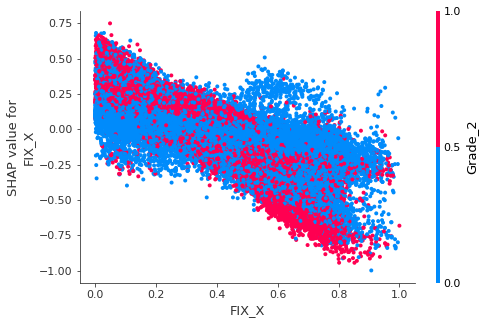

In [32]:
shap.dependence_plot(
    ind=-1, shap_values=shap_values.values, 
    features=x_test,
    feature_names=x_org.columns,
                    )

- 

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


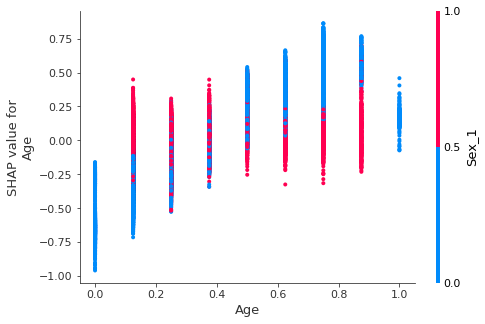

In [34]:
shap.dependence_plot(
    ind=-2, shap_values=shap_values.values, 
    features=x_test,
    feature_names=x_org.columns,
                    )

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


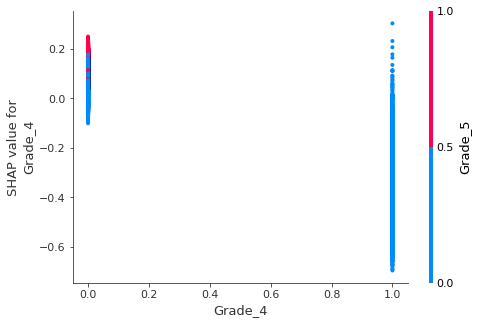

In [36]:
shap.dependence_plot(
    ind=-3, shap_values=shap_values.values, 
    features=x_test,
    feature_names=x_org.columns,
                    )

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


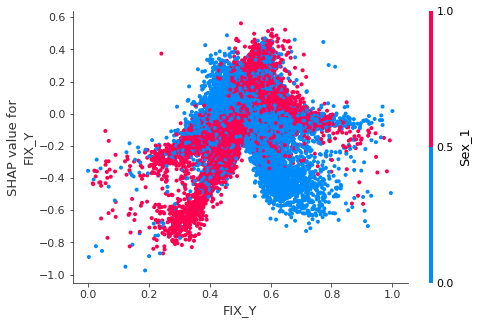

In [37]:
shap.dependence_plot(
    ind=-4, shap_values=shap_values.values, 
    features=x_test,
    feature_names=x_org.columns,
                    )

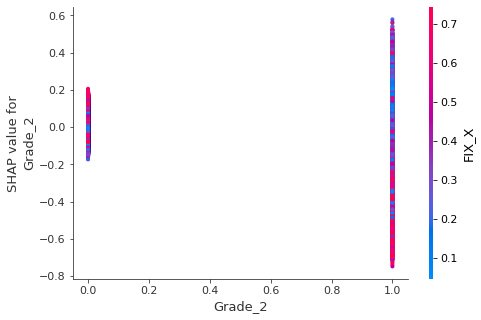

In [38]:
shap.dependence_plot(
    ind=-5, shap_values=shap_values.values, 
    features=x_test,
    feature_names=x_org.columns,
                    )

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


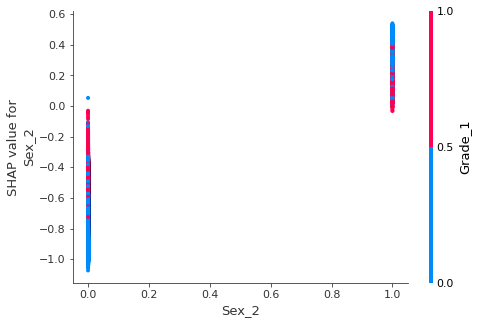

In [39]:
shap.dependence_plot(
    ind=-6, shap_values=shap_values.values, 
    features=x_test,
    feature_names=x_org.columns,
                    )

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


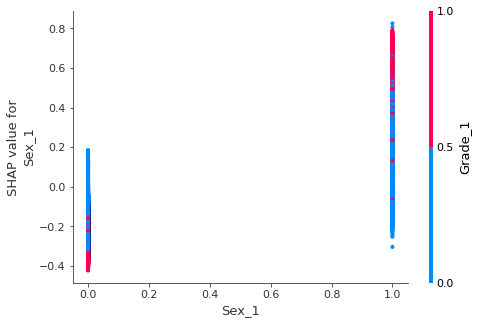

In [40]:
shap.dependence_plot(
    ind=-7, shap_values=shap_values.values, 
    features=x_test,
    feature_names=x_org.columns,
                    )

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


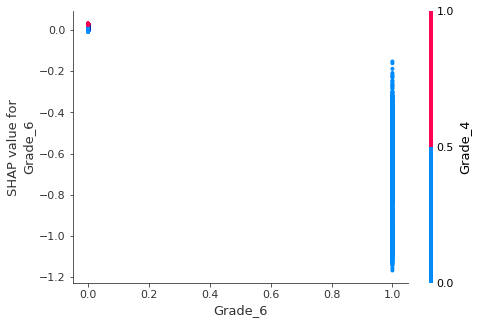

In [41]:
shap.dependence_plot(
    ind=-8, shap_values=shap_values.values, 
    features=x_test,
    feature_names=x_org.columns,
                    )

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


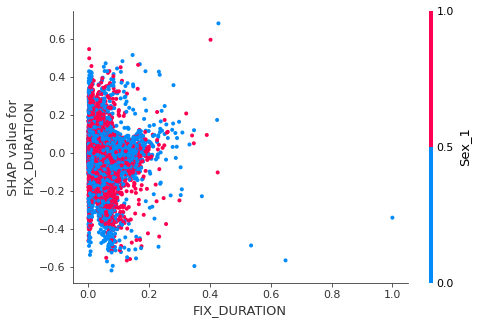

In [42]:
shap.dependence_plot(
    ind=-9, shap_values=shap_values.values, 
    features=x_test,
    feature_names=x_org.columns,
                    )

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


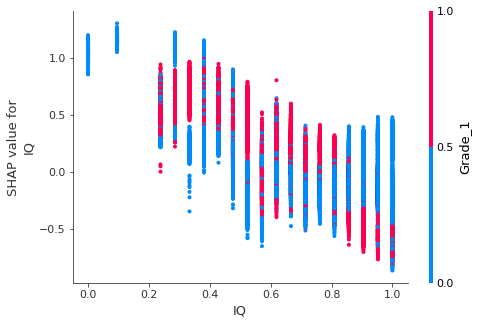

In [45]:
shap.dependence_plot(
    ind=-10, shap_values=shap_values.values, 
    features=x_test,
    feature_names=x_org.columns,
                    )

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


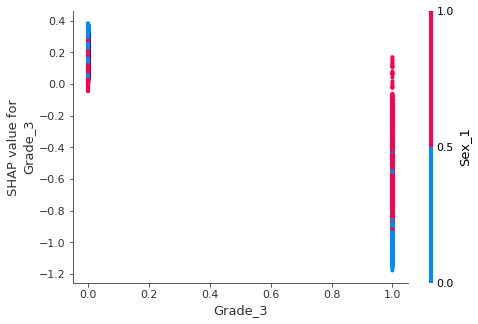

In [47]:
shap.dependence_plot(
    ind=-11, shap_values=shap_values.values, 
    features=x_test,
    feature_names=x_org.columns,
                    )

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


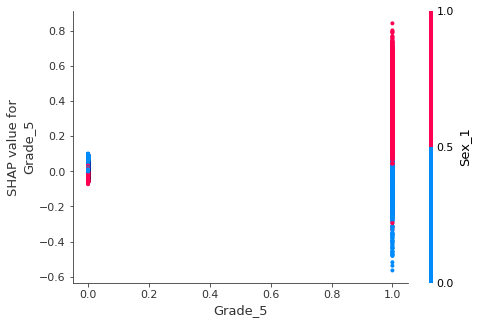

In [48]:
shap.dependence_plot(
    ind=-12, shap_values=shap_values.values, 
    features=x_test,
    feature_names=x_org.columns,
                    )

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


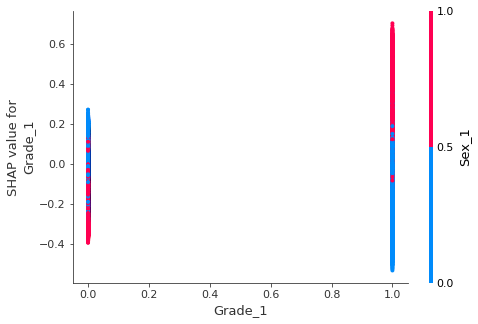

In [49]:
shap.dependence_plot(
    ind=-13, shap_values=shap_values.values, 
    features=x_test,
    feature_names=x_org.columns,
                    )


## Individual force plots of 3 randomly selected samples of each class


In [111]:



normals = np.where(y_test == 1)[0]
at_risks = np.where(y_test == 2)[0]
dyslexics = np.where(y_test == 3)[0]



In [138]:

n_size = 5
np.random.seed(123)
normals_rnd = np.random.choice(normals, n_size)
at_risks_rnd = np.random.choice(at_risks, n_size)
dyslexics_rnd = np.random.choice(dyslexics, n_size)



In [139]:
normals_rnd

array([ 22912,  44359,  26026, 101036, 102838])

In [140]:
at_risks_rnd

array([75422, 85817, 75041, 66011, 23244])

In [141]:
dyslexics_rnd

array([77140, 77665, 69153, 69179, 20035])

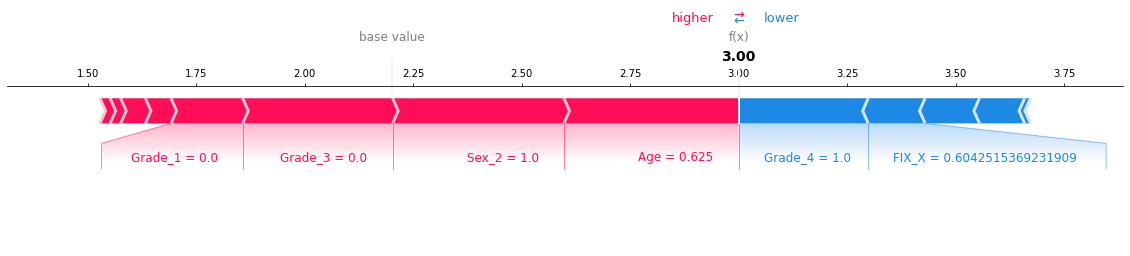

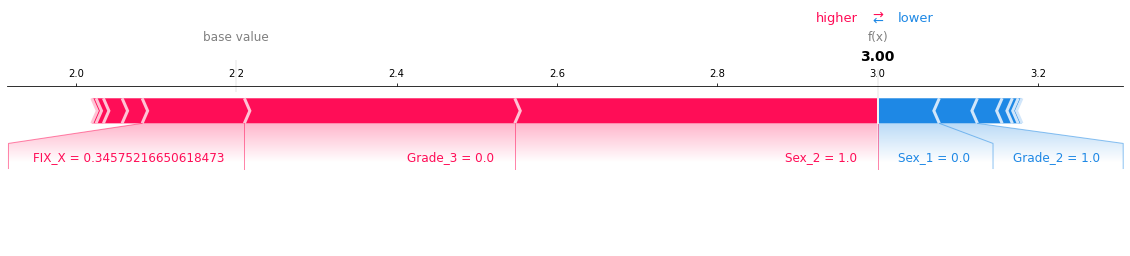

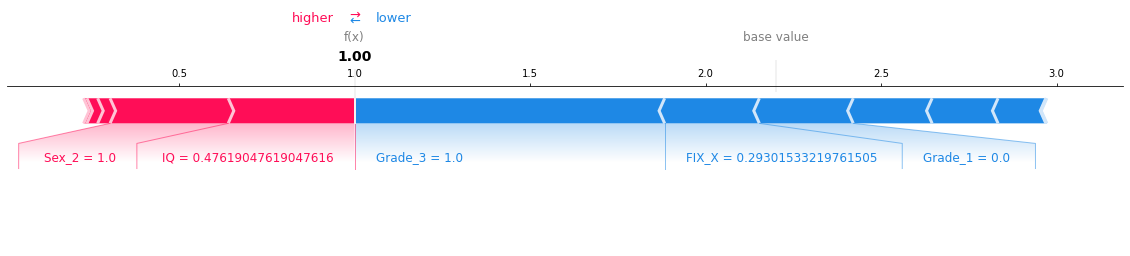

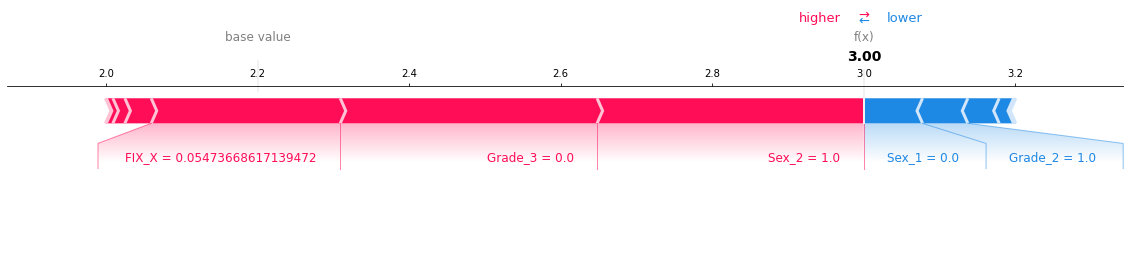

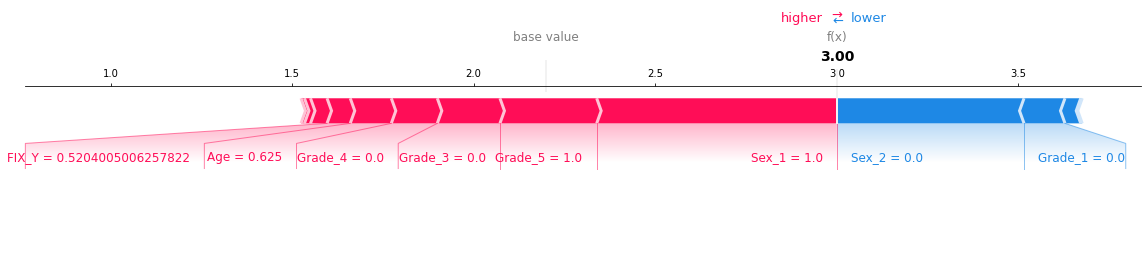

In [142]:
for n in normals_rnd:
    shap.plots.force(shap_values[n], show=False, matplotlib=True)

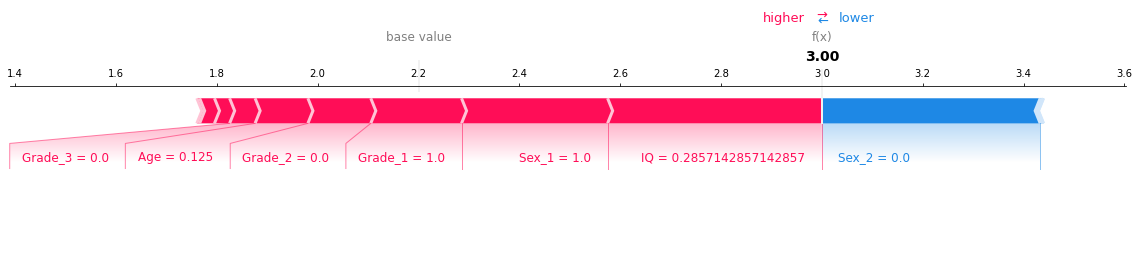

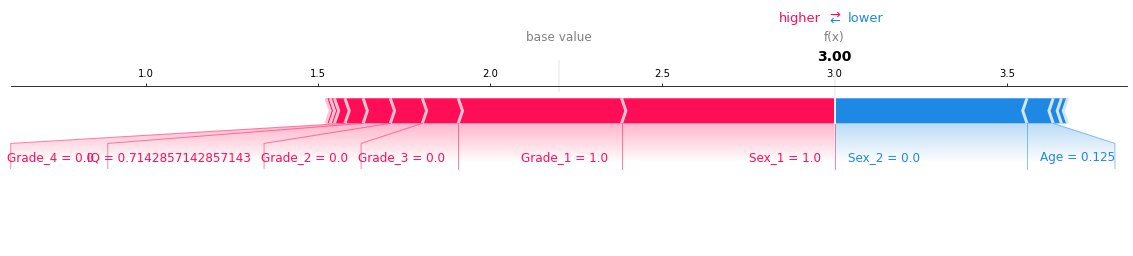

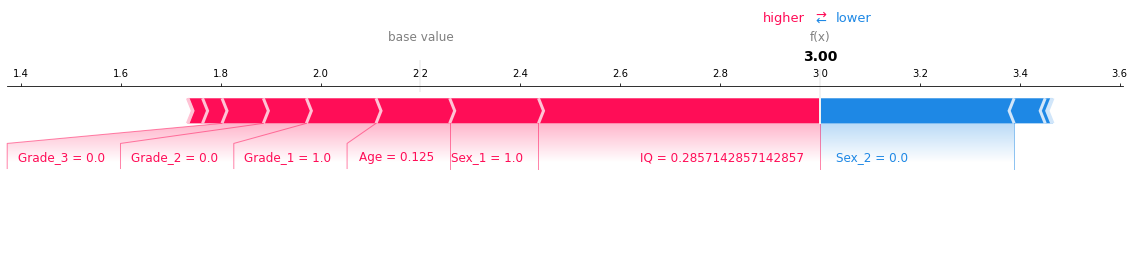

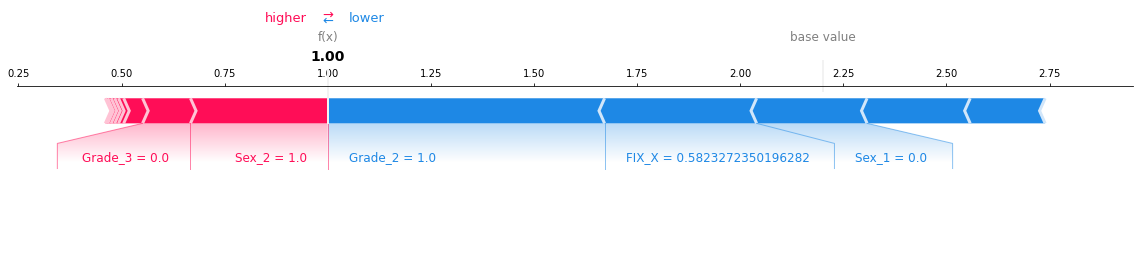

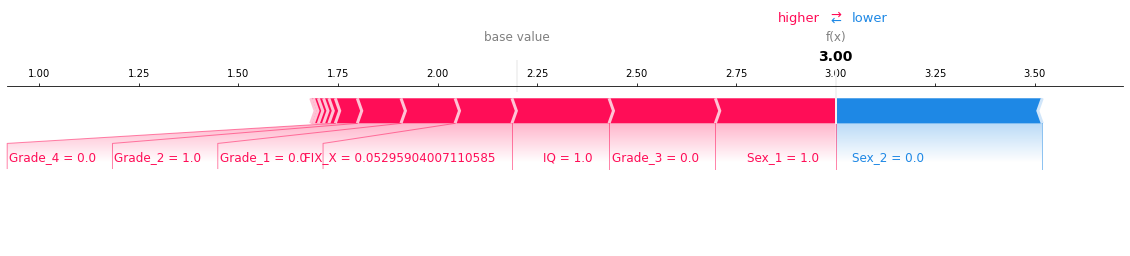

In [143]:
for r in at_risks_rnd:
    shap.plots.force(shap_values[r], show=False, matplotlib=True)
    
    

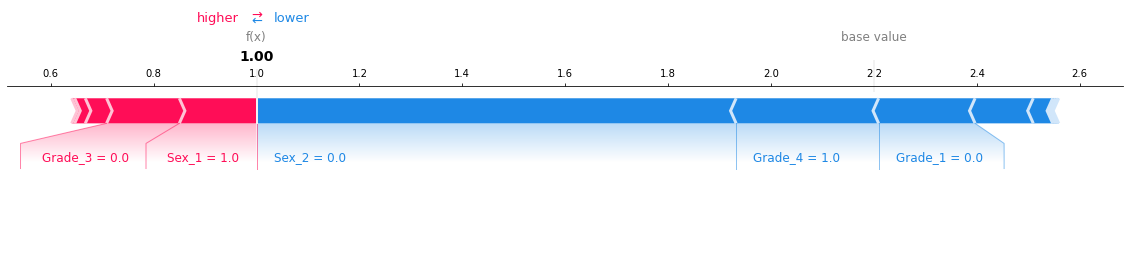

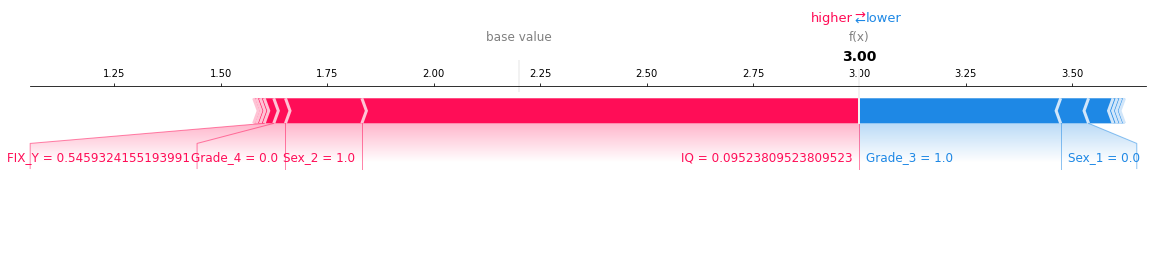

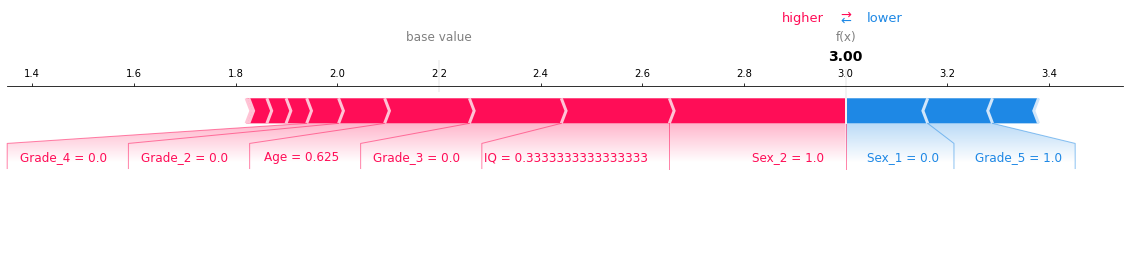

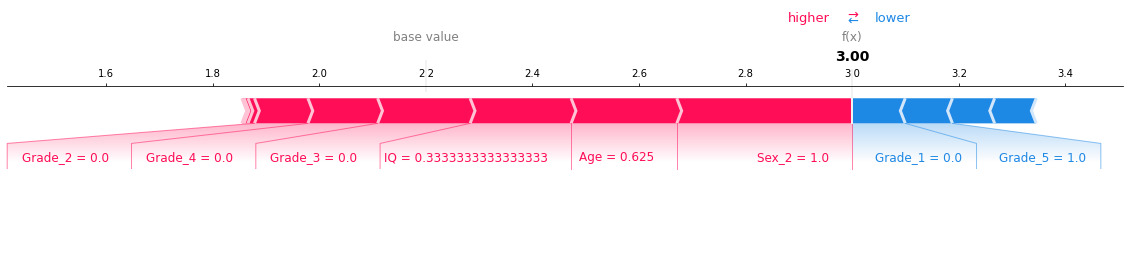

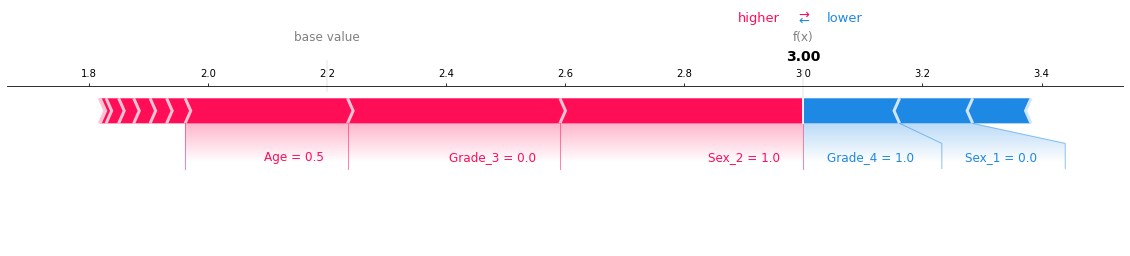

In [144]:
for d in dyslexics_rnd:
    shap.plots.force(shap_values[d], show=False, matplotlib=True)

# a quick check up

In [57]:
n = "dd_ia_demo_phono-mlp_cls--shuffled_True--exclude at risk_0.pickle"




In [181]:
with open ("../../Results/dd_fix_demo-mlp_cls--shuffled:False--exclude at risk:0.pickle", "rb") as fp:
    
    res = pickle.load(fp)
    
    

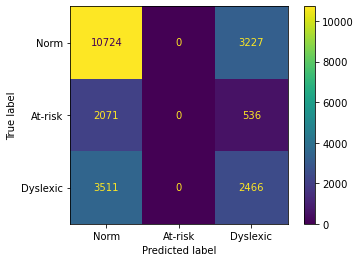

Kappa: 0.1337700875642197 AUC ROC: 0.5303366637417792


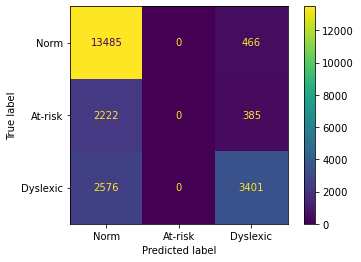

Kappa: 0.44005930294195605 AUC ROC: 0.8201146605443049


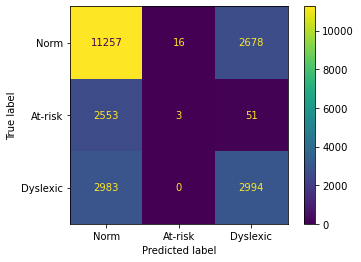

Kappa: 0.22014536198237944 AUC ROC: 0.6417906179870687


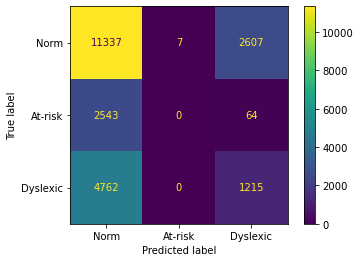

Kappa: -0.0020493498433358237 AUC ROC: 0.5445027227979147


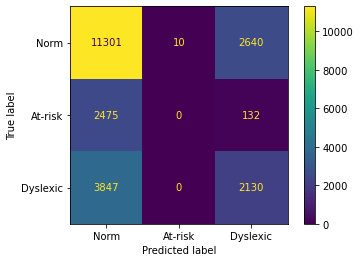

Kappa: 0.11813747060789781 AUC ROC: 0.6303910280578978


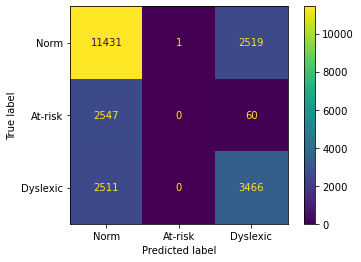

Kappa: 0.28773414605690095 AUC ROC: 0.6961488424116324


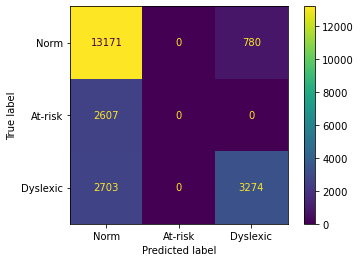

Kappa: 0.3921249424561697 AUC ROC: 0.7014491014261559


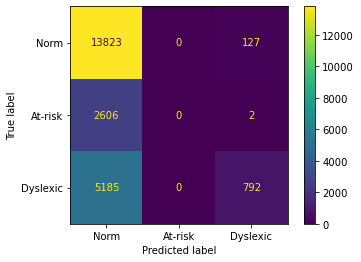

Kappa: 0.1111963586286926 AUC ROC: 0.7195127327938369


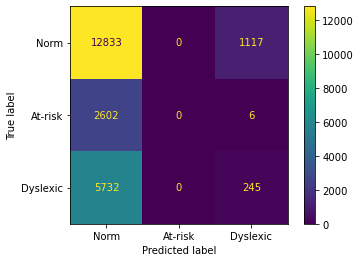

Kappa: -0.04278247458767659 AUC ROC: 0.5417386473648009


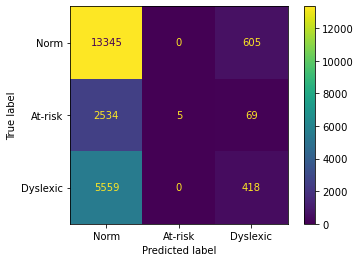

Kappa: 0.023052680498112044 AUC ROC: 0.5895510236440732


In [182]:
for i in range(1, 11):
    i = str(i)
    y_test_ = res[i]["y_test"]
    y_pred_ = res[i]["y_pred"]
    y_prob_ = res[i]["y_pred_prob"]
    
    cm = sklearn.metrics.confusion_matrix(
    y_true=y_test_, 
    y_pred=y_pred_
    )
    
    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names
                             )
    disp.plot()
    plt.show()
    
    
    print(
        "Kappa:", sklearn.metrics.cohen_kappa_score(y1=y_test_, y2=y_pred_),
        
        "AUC ROC:", sklearn.metrics.roc_auc_score(y_test_, y_prob_,
                                                  multi_class="ovr",
                                                  average="weighted")
    )






In [78]:
y_test_ = res["1"]["y_test"]

y_pred_ = res["1"]["y_pred"]
y_prob_ = res["1"]["y_pred_prob"]




In [79]:
cm = sklearn.metrics.confusion_matrix(
    y_true=y_test_, 
    y_pred=y_pred_
)

cm

array([[10724,     0,  3227],
       [ 2071,     0,   536],
       [ 3511,     0,  2466]])

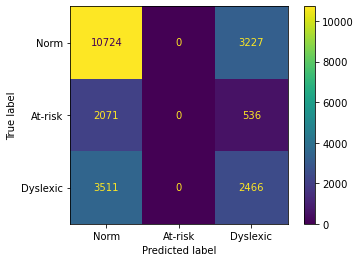

In [80]:
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names
                             )
disp.plot()
plt.show()




In [81]:

sklearn.metrics.cohen_kappa_score(y1=y_test_, y2=y_pred_)



0.1337700875642197

In [82]:


sklearn.metrics.roc_auc_score(y_test_, y_prob_,
                              multi_class="ovr",
                              average="weighted")




0.5303366637417792

In [75]:
y_test__ = o

array([1, 1, 1, ..., 3, 3, 3])

In [ ]:
x_ = x_org.values